In [104]:
from IPython.display import Image

import keras
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pydot
import networkx as nx
from itertools import product

Following the Variational Autoencoder (VAE) example at https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In this notebook, examining visualization of the latent variables in higher dimensions

In [105]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 4
epochs = 50

In [106]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [107]:
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [108]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [109]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [110]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 4)            2052        dense_10[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 4)            2052        dense_10[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [111]:
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

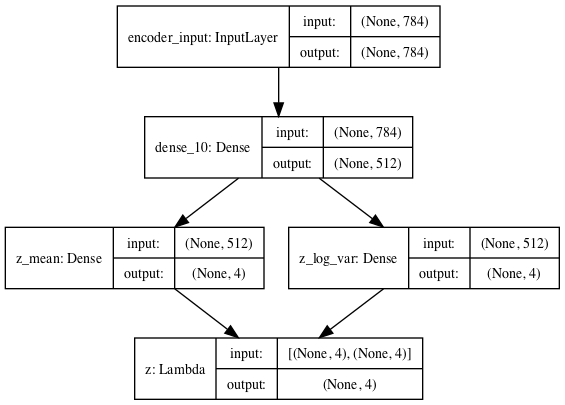

In [112]:
display(Image('vae_mlp_encoder.png'))

In [113]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 4)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_12 (Dense)             (None, 784)               402192    
Total params: 404,752
Trainable params: 404,752
Non-trainable params: 0
_________________________________________________________________


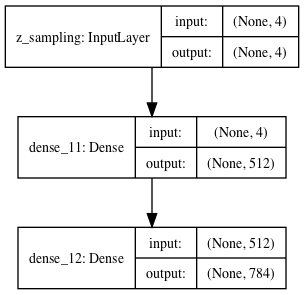

In [114]:
display(Image('vae_mlp_decoder.png'))

In [115]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [116]:
models = (encoder, decoder)
data = (x_test, y_test)
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,to_file='vae_mlp.png',show_shapes=True)

/Users/jon/data/sandbox/keras/ve/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 4), (None, 4), (N 406024    
_________________________________________________________________
decoder (Model)              (None, 784)               404752    
Total params: 810,776
Trainable params: 810,776
Non-trainable params: 0
_________________________________________________________________


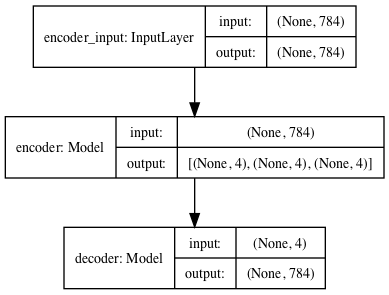

In [117]:
display(Image('vae_mlp.png'))

In [118]:
vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 103us/step - loss: 182.0642 - val_loss: 150.9836
Epoch 2/50
60000/60000 [==============================] - 6s 94us/step - loss: 147.4034 - val_loss: 143.6489
Epoch 3/50
60000/60000 [==============================] - 5s 88us/step - loss: 142.8422 - val_loss: 140.7009
Epoch 4/50
60000/60000 [==============================] - 5s 88us/step - loss: 140.3571 - val_loss: 138.9066
Epoch 5/50
60000/60000 [==============================] - 5s 87us/step - loss: 138.6051 - val_loss: 137.2399
Epoch 6/50
60000/60000 [==============================] - 5s 89us/step - loss: 137.1432 - val_loss: 136.1524
Epoch 7/50
60000/60000 [==============================] - 5s 88us/step - loss: 135.9371 - val_loss: 135.1362
Epoch 8/50
60000/60000 [==============================] - 5s 89us/step - loss: 134.9150 - val_loss: 134.3810
Epoch 9/50
60000/60000 [==============================] - 5s 90us/step - loss

In [119]:
z_mean, _, _ = encoder.predict(x_test,batch_size=batch_size)

In [120]:
d = pd.DataFrame( {'x':z_mean[:,0],'y':z_mean[:,1],'label':y_test} )

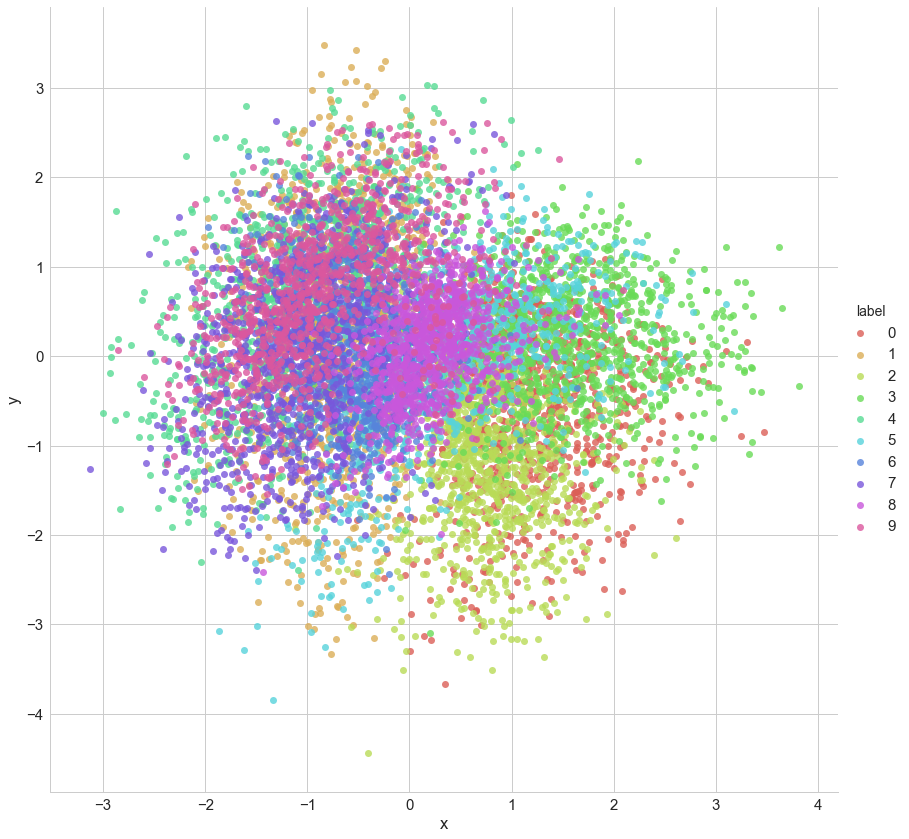

In [121]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set_context('notebook',font_scale=1.5)
sns.set_style('whitegrid')
with sns.color_palette('hls',10):
    sns.lmplot(x="x",y="y",data=d,hue='label',fit_reg=False,size=12)

In [122]:
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]+[0.0]*(latent_dim-2)])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

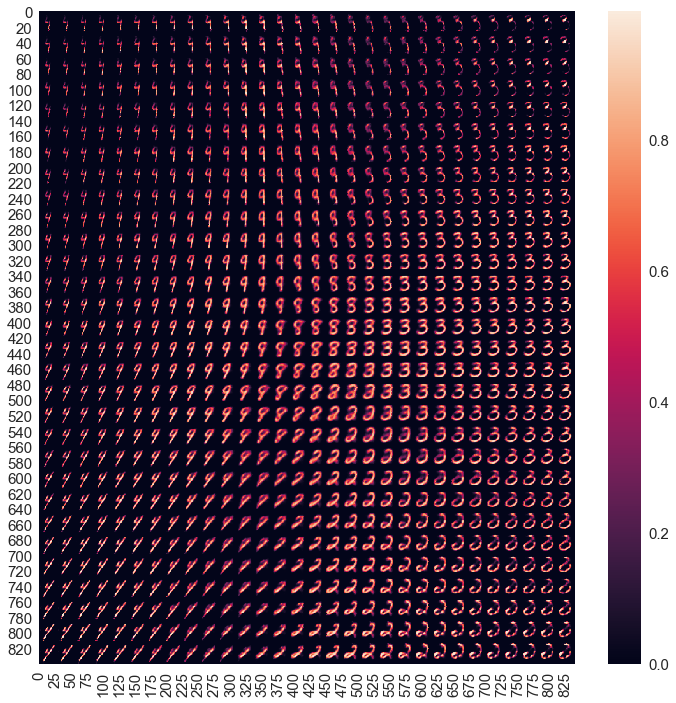

In [123]:
sns.heatmap(figure,xticklabels='auto')

In [124]:
# create nodes
min_z, max_z = -3,3
g = nx.Graph()
latent_samples = [3]*latent_dim
latent_points = np.array(list(product(*[np.linspace(min_z,max_z,latent_samples[i]) for i in range(latent_dim)])))

In [125]:
for i in range(latent_points.shape[0]):
    z_sample = np.array( [latent_points[i,:]] )
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    k = tuple( latent_points[i,j] for j in range(latent_dim) )
    g.add_node( k )
    g.nodes[k]['image_data'] = digit


In [126]:
maxsq = max_z*max_z + 1.0
for i in range(latent_points.shape[0]):
    for j in range(i+1,latent_points.shape[0]):
        if np.dot(latent_points[i]-latent_points[j],latent_points[i]-latent_points[j]) < maxsq:
            k1 = tuple( latent_points[i,k] for k in range(latent_dim) )
            k2 = tuple( latent_points[j,k] for k in range(latent_dim) )
            g.add_edge( k1, k2 )
        

In [127]:
gp = nx.nx_pydot.to_pydot(g)

In [128]:
import PIL
import PIL.Image
import base64
import os

# unfortunately graphviz doesn't support img from data
def get_base64_data( img_data ):
    img = PIL.Image.fromarray((img_data*255.0).astype('uint8'))
    img = img.convert('RGB')
    img.save('tmp.png')
    with open("tmp.png", "rb") as infile:
        enc = base64.b64encode(infile.read())
    return enc.decode('utf-8')

os.system('mkdir -p node_images')

def generate_image_file( _id, img_data ):
    img = PIL.Image.fromarray((img_data*255.0).astype('uint8'))
    img = img.convert('RGB')
    f = os.path.abspath('node_images/%s.png'%_id)
    img.save(f)
    return f

In [129]:
for i,(n,m) in enumerate(zip( gp.get_nodes(), g.nodes() )):
    img = generate_image_file( i, g.nodes[m]['image_data'] )
    n.set_label( '<<table border="0"><tr><td><img src="%s"/></td></tr></table>>'%img )
    #n.set_label( '<<img src="%s"/>>'%img )

In [130]:
gp.write_png('tst.png')

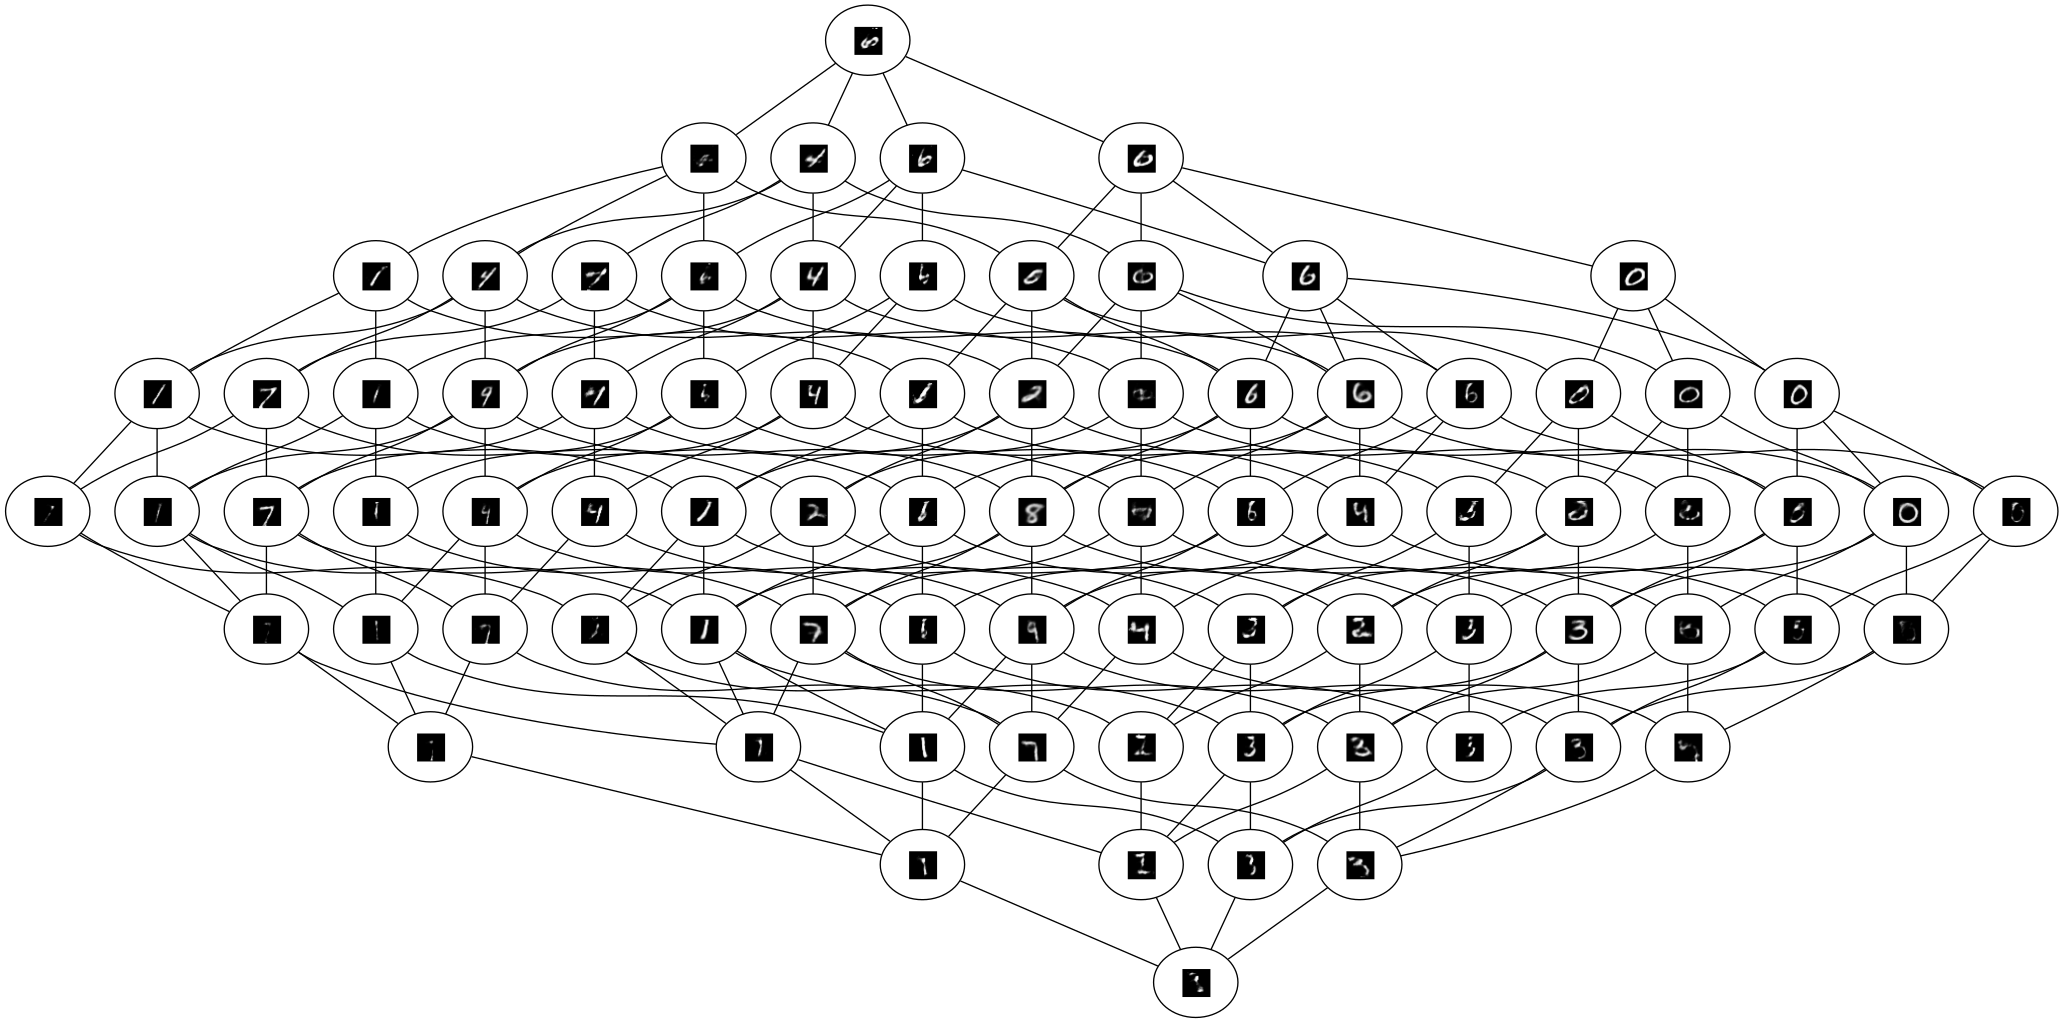

In [131]:
display(Image('tst.png'))

In [133]:
# TODO: measure actual limits of z and use more appropriate grid